# Southern Africa - Ground-based gravity

This is a public domain compilation of ground measurements of gravity from
Southern Africa.
The observations are the absolute gravity values in mGal.

**Source:** [NOAA NCEI](https://www.ngdc.noaa.gov/mgg/gravity/)

**License:** [public domain](https://ngdc.noaa.gov/ngdcinfo/privacy.html)

## Notes

From the [dataset description](https://www.ngdc.noaa.gov/mgg/gravity/1999/data/regional/africa/africa.txt):

> This data base (14,559 records) was received in January 1986. Principal gravity parameters include elevation and observed gravity.  The observed gravity values are referenced to the International Gravity Standardization Net 1971 (IGSN 71).  The data are randomly distributed within the boundaries of the Republic of South Africa.

The horizontal datum is not specified and heights are referenced to "sea
level", which we will interpret as the geoid (which realization is likely not
relevant since the uncertainty in the height is probably larger than geoid
model differences).

Heights will remain the same and we'll conversion to geometric heights to be done in tutorials for better educational purposes.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import verde as vd
import pooch
import pygmt

## Download the data

Use [Pooch](https://github.com/fatiando/pooch) to download the original data file to our computer.

In [2]:
fname = pooch.retrieve(
    url="https://www.ngdc.noaa.gov/mgg/gravity/1999/data/regional/africa/africa.ast",
    known_hash="md5:9eab1ed16d1689f4da579e7084fe1203",
)
print(f"size: {os.path.getsize(fname) / 1e6} Mb")

size: 0.611478 Mb


## Read the data

Use pandas to read the data.

In [3]:
data = pd.read_csv(
    fname, 
    delim_whitespace=True, 
    header=None, 
    names=["latitude", "longitude", "height_sea_level_m", "gravity_mgal"],
)
data

,latitude,longitude,height_sea_level_m,gravity_mgal
0,-34.39150,17.71900,-589.0,979724.79
1,-34.48000,17.76100,-495.0,979712.90
2,-34.35400,17.77433,-406.0,979725.89
3,-34.13900,17.78500,-267.0,979701.20
4,-34.42200,17.80500,-373.0,979719.00
...,...,...,...,...
14554,-17.95833,21.22500,1053.1,978182.09
14555,-17.98333,21.27500,1033.3,978183.09
14556,-17.99166,21.70833,1041.8,978182.69
14557,-17.95833,21.85000,1033.3,978193.18


## Remove points well below sea level

Some points are 100s of meters below sea level. This is very suspicious and are potentially flawed heights from shipborne measurements. Remove these points (it's not many) just to be safe.

In [4]:
data = data[data.height_sea_level_m >= 0].reset_index(drop=True)
data

,latitude,longitude,height_sea_level_m,gravity_mgal
0,-34.12971,18.34444,32.2,979656.12
1,-34.08833,18.36028,592.5,979508.21
2,-34.19583,18.37418,18.4,979666.46
3,-34.23972,18.40388,25.0,979671.03
4,-34.16444,18.41112,228.7,979616.11
...,...,...,...,...
14354,-17.95833,21.22500,1053.1,978182.09
14355,-17.98333,21.27500,1033.3,978183.09
14356,-17.99166,21.70833,1041.8,978182.69
14357,-17.95833,21.85000,1033.3,978193.18


## Plot the data 

Make a quick plot to make sure the data look OK. This plot will be used as a preview of the dataset.

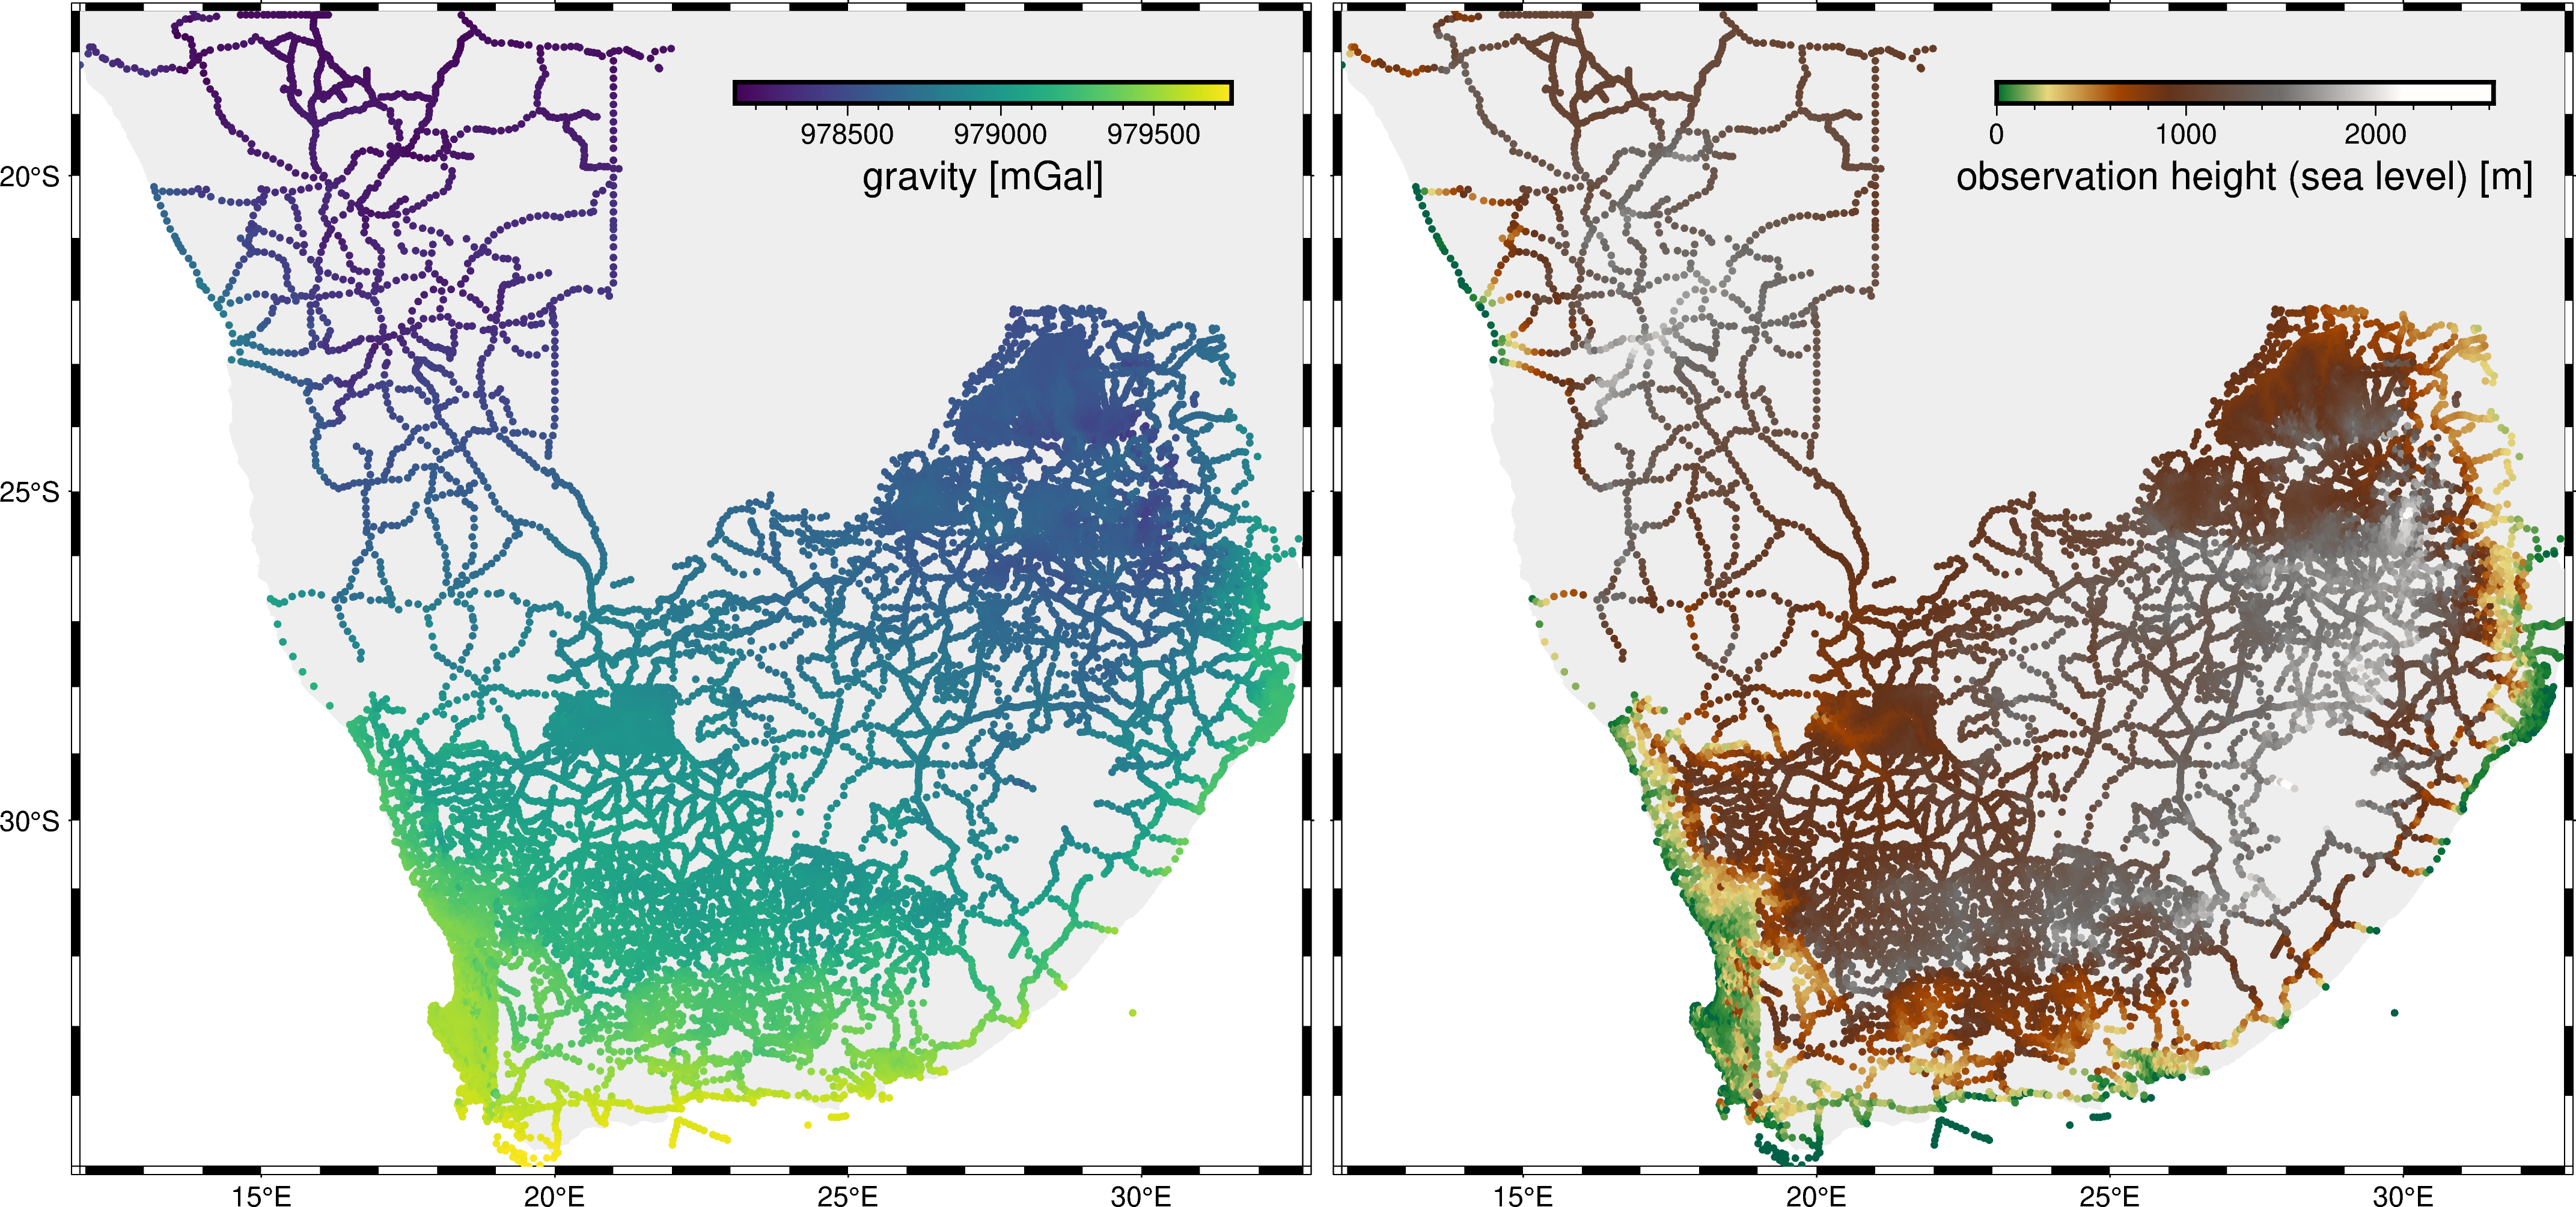

In [5]:
region = vd.get_region((data.longitude, data.latitude))

fig = pygmt.Figure()
with fig.subplot(
    nrows=1,
    ncols=2,
    figsize=("35c", "20c"),
    sharey="l",  # shared y-axis on the left side
    frame="WSrt",
):
    with fig.set_panel(0):
        fig.basemap(region=region, projection="M?", frame="af")
        fig.coast(area_thresh=1e4, land="#eeeeee")  
        pygmt.makecpt(cmap="viridis", series=[data.gravity_mgal.min(), data.gravity_mgal.max()])
        fig.plot(
            x=data.longitude,
            y=data.latitude,
            color=data.gravity_mgal,
            cmap=True,
            style="c0.1c",
        )    
        fig.colorbar(
            frame='af+l"gravity [mGal]"',
            position="jTR+w7c/0.3c+h+o1/1",
        )
    with fig.set_panel(1):
        fig.basemap(region=region, projection="M?", frame="af")
        fig.coast(area_thresh=1e4, land="#eeeeee")  
        pygmt.makecpt(cmap="geo", series=[data.height_sea_level_m.min(), data.height_sea_level_m.max()])
        fig.plot(
            x=data.longitude,
            y=data.latitude,
            color=data.height_sea_level_m,
            cmap=True,
            style="c0.1c",
        )    
        fig.colorbar(
            frame='af+l"observation height (sea level) [m]"',
            position="jTR+w7c/0.3c+h+o1/1",
        )
fig.savefig("preview.jpg", dpi=200)
fig.show(width=1000)

## Export

Make a separate DataFrame to export to a compressed CSV. The conversion is needed to specify the number of significant digits to preserve in the output. Setting this along with the LZMA compression can help reduce the file size considerably. Not all fields in the original data need to be exported.

In [6]:
export = pd.DataFrame({
    "longitude": data.longitude.map(lambda x: "{:.5f}".format(x)),
    "latitude": data.latitude.map(lambda x: "{:.5f}".format(x)),    
    "height_sea_level_m": data.height_sea_level_m.map(lambda x: "{:.1f}".format(x)),
    "gravity_mgal": data.gravity_mgal.map(lambda x: "{:.2f}".format(x)),
})
export

,longitude,latitude,height_sea_level_m,gravity_mgal
0,18.34444,-34.12971,32.2,979656.12
1,18.36028,-34.08833,592.5,979508.21
2,18.37418,-34.19583,18.4,979666.46
3,18.40388,-34.23972,25.0,979671.03
4,18.41112,-34.16444,228.7,979616.11
...,...,...,...,...
14354,21.22500,-17.95833,1053.1,978182.09
14355,21.27500,-17.98333,1033.3,978183.09
14356,21.70833,-17.99166,1041.8,978182.69
14357,21.85000,-17.95833,1033.3,978193.18


Save the data to a file and calculate the size and MD5/SHA256 hashes.

In [7]:
output = "southern-africa-gravity.csv.xz"
export.to_csv(output, index=False)
print(f"file: {output}")
print(f"size: {os.path.getsize(output) / 1e6} Mb")
for alg in ["md5", "sha256"]:
    print(f"{alg}:{pooch.file_hash(output, alg=alg)}")

file: southern-africa-gravity.csv.xz
size: 0.138108 Mb
md5:1dee324a14e647855366d6eb01a1ef35
sha256:f5f8e5eb6cd97f104fbb739cf389113cbf28ca8ee003043fab720a0fa7262cac


## Read back the data and plot it

Verify that the output didn't corrupt anything.

In [8]:
data_reloaded = pd.read_csv(output)
data_reloaded

,longitude,latitude,height_sea_level_m,gravity_mgal
0,18.34444,-34.12971,32.2,979656.12
1,18.36028,-34.08833,592.5,979508.21
2,18.37418,-34.19583,18.4,979666.46
3,18.40388,-34.23972,25.0,979671.03
4,18.41112,-34.16444,228.7,979616.11
...,...,...,...,...
14354,21.22500,-17.95833,1053.1,978182.09
14355,21.27500,-17.98333,1033.3,978183.09
14356,21.70833,-17.99166,1041.8,978182.69
14357,21.85000,-17.95833,1033.3,978193.18


Make the figure again but don't save it to a file this time.

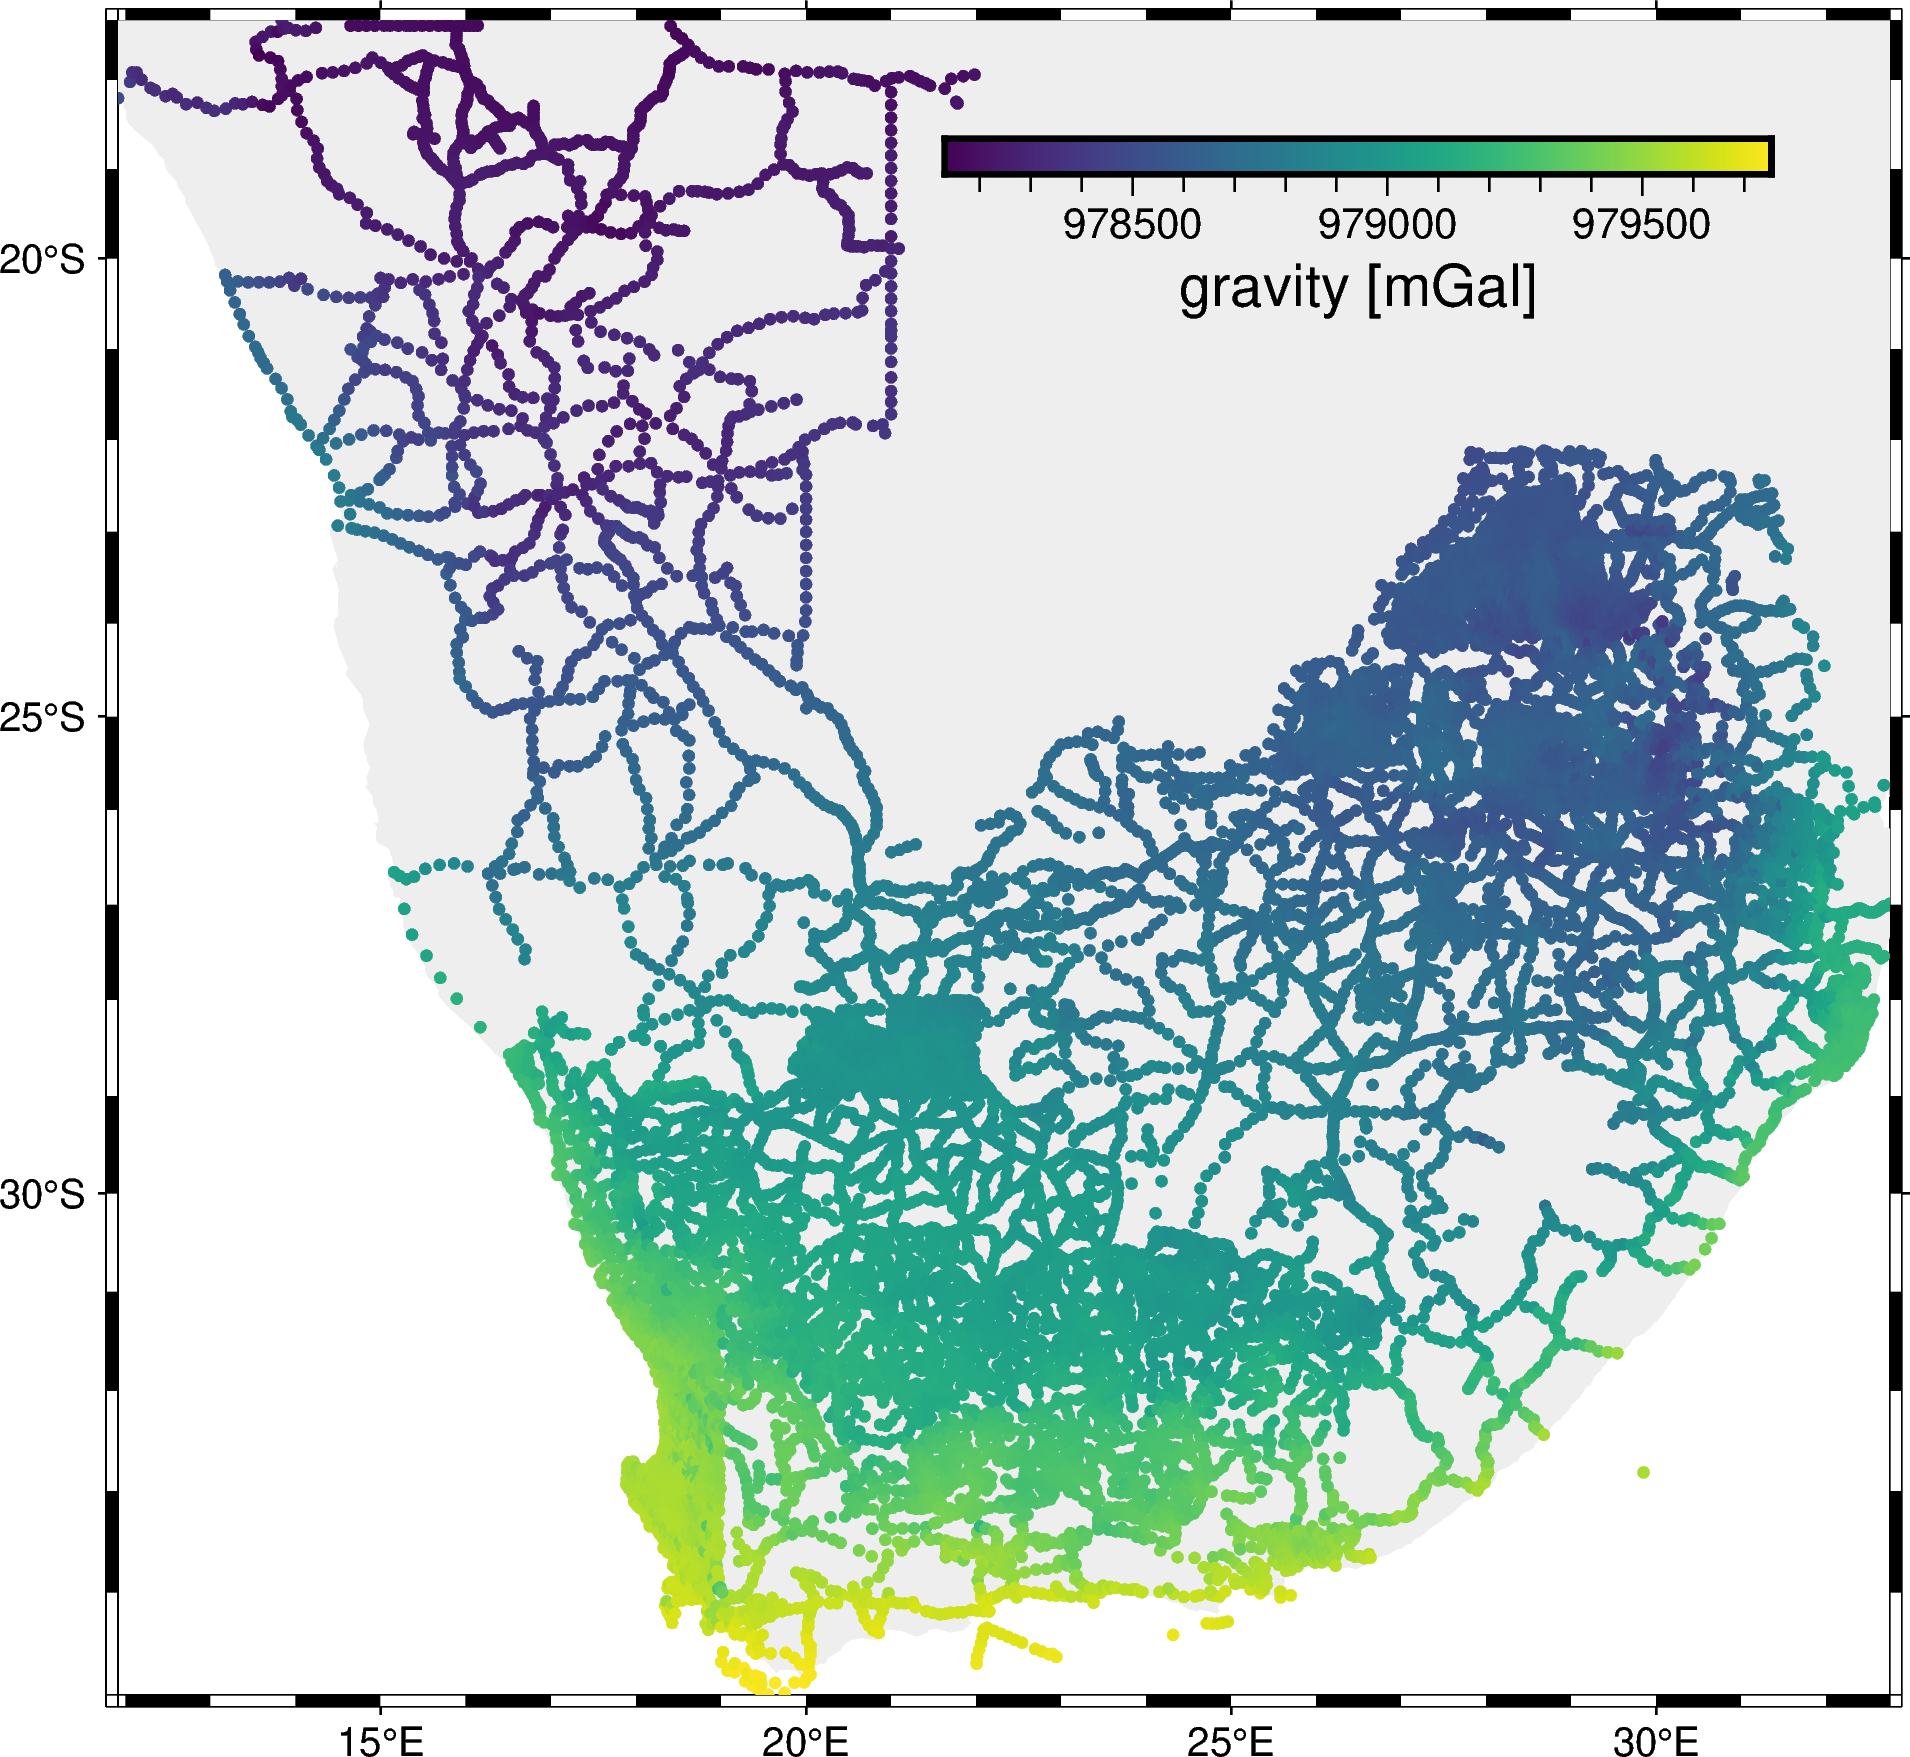

In [9]:
fig = pygmt.Figure()
fig.basemap(region=region, projection="M15c", frame="af")
fig.coast(area_thresh=1e4, land="#eeeeee")  
pygmt.makecpt(cmap="viridis", series=[data_reloaded.gravity_mgal.min(), data_reloaded.gravity_mgal.max()])
fig.plot(
    x=data_reloaded.longitude,
    y=data_reloaded.latitude,
    color=data_reloaded.gravity_mgal,
    cmap=True,
    style="c0.1c",
)    
fig.colorbar(
    frame='af+l"gravity [mGal]"',
    position="jTR+w7c/0.3c+h+o1/1",
)        
fig.show()